https://medium.com/@okanyenigun/step-by-step-guide-to-bayesian-optimization-a-python-based-approach-3558985c6818

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

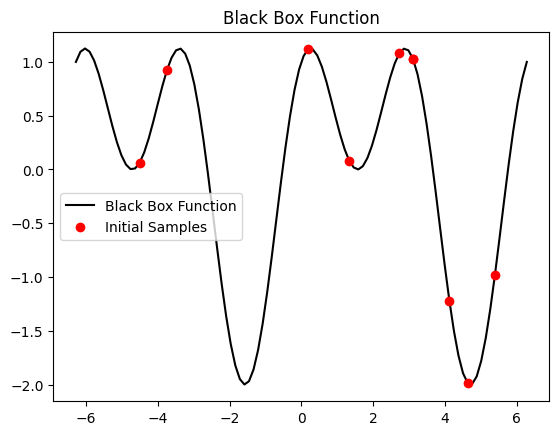

In [2]:
def black_box(x):
    return np.sin(x) + np.cos(2*x)

x = np.linspace(-2*np.pi, 2*np.pi, 100)
y = black_box(x)

# initial samples
num_samples = 10
sample_x = np.random.choice(x, size=num_samples)
sample_y = black_box(sample_x)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, y, label='Black Box Function', color='black')
ax.scatter(sample_x, sample_y, label='Initial Samples', zorder=5, color='red')
ax.set_title('Black Box Function')
ax.legend()

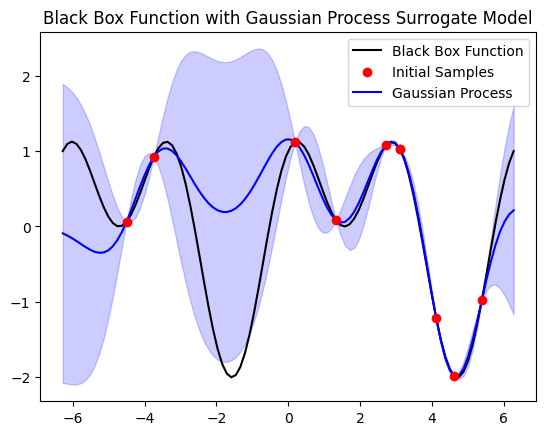

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Gaussian process regressor with RBF kernel
kernel = RBF(length_scale=1)
gp_model = GaussianProcessRegressor(kernel=kernel)

# Fit model to sampled points
gp_model.fit(sample_x.reshape(-1, 1), sample_y)

# Generate predictions
y2_pred, y2_std = gp_model.predict(x.reshape(-1, 1), return_std=True)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, y, label='Black Box Function', color='black')
ax.scatter(sample_x, sample_y, label='Initial Samples', zorder=5, color='red')

ax.plot(x, y2_pred, label='Gaussian Process', color='blue')
ax.fill_between(x, y2_pred - 2*y2_std, y2_pred + 2*y2_std, color='blue', alpha=0.2)
ax.set_title('Black Box Function with Gaussian Process Surrogate Model')
ax.legend()

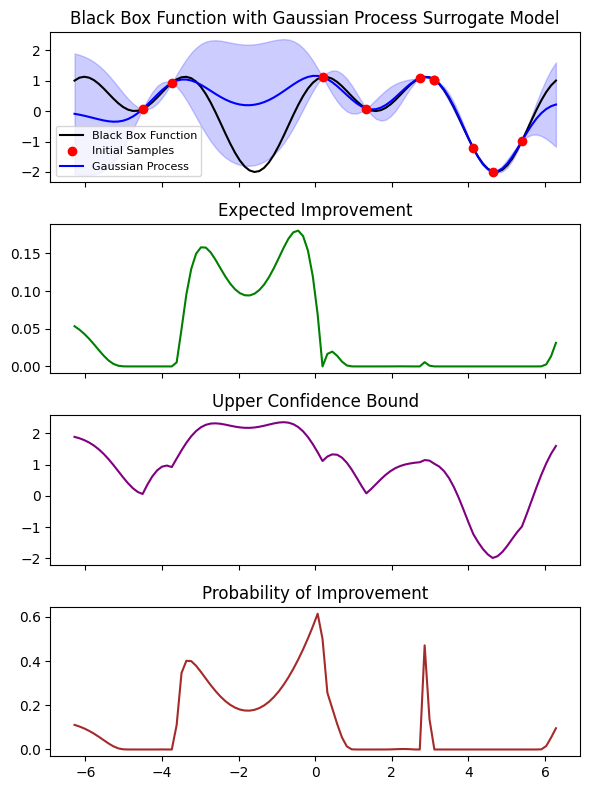

In [4]:
from scipy.stats import norm

# Expected improvement acquisition function
def expected_improvement(x, gp_model, best_y):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    z = (y_pred - best_y) / y_std
    ei = (y_pred - best_y) * norm.cdf(z) + y_std * norm.pdf(z)
    return ei

# Determine the point with the highest observed function value
best_idx = np.argmax(sample_y)
best_x = sample_x[best_idx]
best_y = sample_y[best_idx]

ei = expected_improvement(x, gp_model, best_y)

# Upper confidence bound acquisition function
def upper_confidence_bound(x, gp_model, beta):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    ucb = y_pred + beta * y_std
    return ucb

beta = 2.0
ucb = upper_confidence_bound(x, gp_model, beta)

# Probability of improvement
def probability_of_improvement(x, gp_model, best_y):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    z = (y_pred - best_y) / y_std
    pi = norm.cdf(z)
    return pi

pi = probability_of_improvement(x, gp_model, best_y)


# Create plots
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6, 8))
ax[0].plot(x, y, label='Black Box Function', color='black')
ax[0].scatter(sample_x, sample_y, label='Initial Samples', zorder=5, color='red')

ax[0].plot(x, y2_pred, label='Gaussian Process', color='blue')
ax[0].fill_between(x, y2_pred - 2*y2_std, y2_pred + 2*y2_std, color='blue', alpha=0.2)
ax[0].set_title('Black Box Function with Gaussian Process Surrogate Model')
ax[0].legend(fontsize=8)

ax[1].plot(x, ei, color='green')
ax[1].set_title('Expected Improvement')

ax[2].plot(x, ucb, color='purple')
ax[2].set_title('Upper Confidence Bound')

ax[3].plot(x, pi, color='brown')
ax[3].set_title('Probability of Improvement')

fig.tight_layout()

/Users/msimoni/repos/ML-AI-tutorials.git/venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


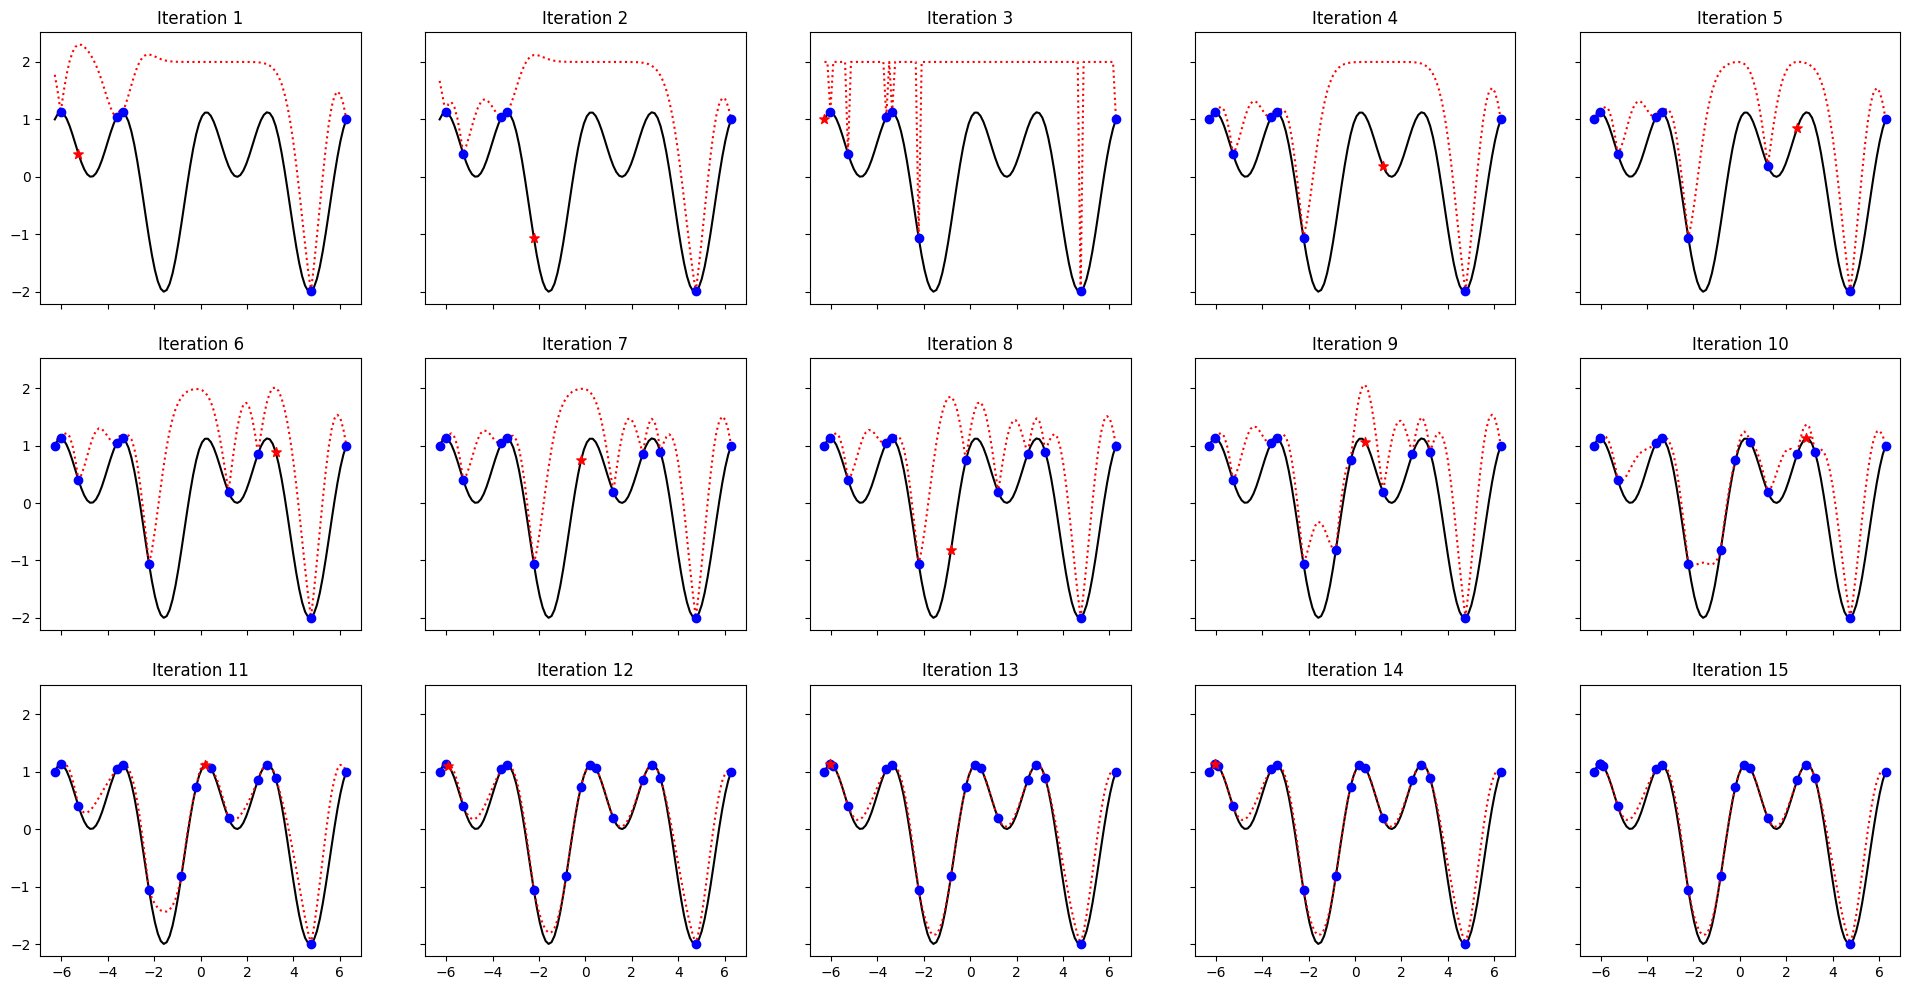

In [5]:

def show_iterations(num_iterations, num_samples):
    fig_size = {
        5: {'rows': 1, 'height': 4},
        10: {'rows': 2, 'height': 8},
        15: {'rows': 3, 'height': 12},
        20: {'rows': 4, 'height': 16},
        25: {'rows': 5, 'height': 20},
        30: {'rows': 6, 'height': 24},
        35: {'rows': 7, 'height': 30},
    }
    
    if num_iterations not in fig_size:
        raise ValueError(f'Invalid iterations. Allowed iterations: {list(fig_size.keys())}')

    fig, ax = plt.subplots(nrows=fig_size[num_iterations]['rows'], ncols=5, figsize=(24, fig_size[num_iterations]['height']), sharex=True, sharey=True)
    ax = ax.flatten()

    x = np.linspace(-2*np.pi, 2*np.pi, 100)
    y = black_box(x)

    # initial samples
    sample_x = np.random.choice(x, size=num_samples)
    sample_y = black_box(sample_x)

    for i in range(num_iterations):
        # Fit the Gaussian Process model to the sampled points
        gp_model.fit(sample_x.reshape(-1, 1), sample_y)

        # Use UCB acquisition function
        beta = 2
        ucb = upper_confidence_bound(x, gp_model, beta)

        ax[i].plot(x, y, label='Black Box Function', color='black')
        ax[i].plot(x, ucb, label='Surrogate Function (UCB)', color='red', linestyle='dotted')
        ax[i].scatter(sample_x, sample_y, color='blue', label='Previous Points', zorder=5)

        if i < num_iterations - 1:
            # Select the next point based on the acquisition function
            new_x = x[np.argmax(ucb)]
            new_y = black_box(new_x)
            sample_x = np.append(sample_x, new_x)
            sample_y = np.append(sample_y, new_y)
            ax[i].scatter(new_x, new_y, color='red', label='New Point', zorder=5, marker='*', s=50)
        
        ax[i].set_title(f'Iteration {i+1}')
        # ax[i].legend(fontsize=8)
        

show_iterations(num_iterations=15, num_samples=5)